In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os, time, math, csv
import itertools
import collections

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import scipy.optimize

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.model_selection import KFold

import MigrationModels
import MigrationEvaluationMethods

#simple-maps
sys.path.append(os.path.join(os.getcwd(),"simple-maps"))
from simplemaps.SimpleFigures import simpleMap, differenceMap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import keras
import keras.backend as K
from keras.optimizers import SGD, Adam
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, AlphaDropout, Input, BatchNormalization, Activation
from keras.callbacks import TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib 

from imblearn.under_sampling import RandomUnderSampler, AllKNN, NearMiss, CondensedNearestNeighbour
from imblearn.over_sampling import SMOTE

import xgboost as xgb

# Initial setup

In [3]:
years = range(2004, 2014 + 1)

In [4]:
shapefile_fn = "data/intermediate/boundary_shapefiles/cb_2015_us_county_500k.shp"
shapefile_key = "GEOID"

# Load data

### Migration data

In [5]:
migration_matrices = [
    np.load("data/processed/migration/migration_matrix_%d.npy" % (year))
    for year in years
]

for migration_matrix in migration_matrices:
    np.fill_diagonal(migration_matrix, 0.0)

f = open("data/processed/county_intersection_list_2004_2014.txt")
county_list = f.read().strip().split("\n")
f.close()

county_fips_to_idx = {fips:idx for idx, fips in enumerate(county_list)}
num_counties = len(county_list)

In [19]:
f = open("data/processed/hurricane_affected_counties.csv", "r")
flooded_counties = f.read().strip().split("\n")
f.close()

unflooded_counties = [fips for fips in county_list if fips not in flooded_counties]

flooded_county_idxs = np.array([county_fips_to_idx[fips] for fips in flooded_counties])
unflooded_county_idxs = np.array([county_fips_to_idx[fips] for fips in unflooded_counties])

all_county_idxs = np.array(list(range(num_counties)))

### Per county features

In [7]:
population_by_year = pd.read_csv("data/processed/county_population_2004_2014.csv", dtype={"FIPS":str})
population_by_year = population_by_year.set_index("FIPS")

population_vectors_by_year = [population_by_year["POPESTIMATE%d" % (year)].values.reshape(-1,1) for year in years]

### Extra features

In [8]:
distances = np.load("data/processed/county_distance_matrix.npy")

In [9]:
intervening_population_opportunities = []
for i in range(len(years)):
    s = MigrationModels.getInterveningOpportunities(population_vectors_by_year[i], distances)
    intervening_population_opportunities.append(s)

# Experiments

In [11]:
def get_full_dataset(year_idx, origin_list, destination_list, model=None):

    origin_pop = population_vectors_by_year[year_idx][origin_list,:].astype(float)
    destination_pop = population_vectors_by_year[year_idx][destination_list,:].astype(float)
    S = intervening_population_opportunities[year_idx][origin_list,:][:,destination_list].astype(float)
    D = distances[origin_list,:][:,destination_list].astype(float)
    T = migration_matrices[year_idx][origin_list,:][:,destination_list].astype(float)

    t_model = LinearRegression(fit_intercept=False)
    t_model.fit(origin_pop, T.sum(axis=1))
    beta = t_model.coef_[0]

    args = {
        "origin_pop": origin_pop,
        "destination_pop": destination_pop,
        "S": S,
        "D": D,
        "T": T,
        "beta": beta,
        "model": model
    }
    return args

In [21]:
def get_pairs_from_full_dataset(args):
    
    "origin_pop": origin_pop,
    "destination_pop": destination_pop,
    "S": S,
    "D": D,
    "T": T,
        
    origin_pop = args["origin_pop"]
    destination_pop = args["destination_pop"]
    
    num_rows, num_cols = len(origin_list), len(destination_list)
    num_entries = num_rows * num_cols
    num_features = 4
    
    X = np.zeros((num_entries, num_features), dtype=float)
    Y = np.zeros(num_entries, dtype=float)    
    
    for i in range(num_rows):
        for j in range(num_cols):
            
            idx = (i*num_cols) + j
            
            origin_idx = origin_list[i]
            dest_idx = destination_list[j]
            
            X[idx,:] = [
                population_vectors_by_year[year_idx][origin_idx],
                population_vectors_by_year[year_idx][dest_idx],
                distances[origin_idx, dest_idx],
                intervening_population_opportunities[year_idx][origin_idx, dest_idx],
            ]
            
            Y[idx] = migrationMatrices[year_idx][origin_idx, dest_idx]

    return X, Y

In [12]:
def run_traditional_models(alpha, args):
    model = args["model"]
    origin_pop, destination_pop = args["origin_pop"], args["destination_pop"]
    S, D, T = args["S"], args["D"], args["T"]
    beta = args["beta"]
    
    if model == "extrad":
        P = MigrationModels.extendedRadiationModel(origin_pop, destination_pop, S, alpha)
    elif model == "rad":
        P = MigrationModels.radiationModel(origin_pop, destination_pop, S)
    elif model == "gravpow":
        P = MigrationModels.gravityModel(origin_pop, destination_pop, D, alpha, decay="power")
    elif model == "gravexp":
        P = MigrationModels.gravityModel(origin_pop, destination_pop, D, alpha, decay="exponential")
    
    P = MigrationModels.row_normalize(P)
    T_pred = MigrationModels.productionFunction(origin_pop, P, beta=beta)
    
    return T, T_pred

def fit_traditional_models(alpha, args):
    T, T_pred = run_traditional_models(alpha, args)
    
    score = MigrationEvaluationMethods.cpc(T, T_pred)    
    return -score
    
def evaluate_traditional_models(alpha, args):
    T, T_pred = run_traditional_models(alpha, args)
    D = args["D"]
    
    return MigrationEvaluationMethods.evaluate_all(T, T_pred, D)

## Traditional models

### Flooded to Unflooded

In [14]:
models = [
    "gravexp",
    "gravpow",
    "rad",
    "extrad"
]

In [15]:
print("Flooded to Unflooded")
flooded_to_unflooded_cv = {}
for model in models:
    print(model)
    results = []
    
    for county in flooded_county_idxs:
        
        t_train_counties = list(set(flooded_county_idxs) - set([county]))
        t_test_counties = [county]
    
        # Train
        args = get_full_dataset(1, t_train_counties, unflooded_county_idxs, model=model)

        opt_result = scipy.optimize.minimize(fit_traditional_models, x0=[1.0], args=args, bounds=[[0,3]])
        alpha = opt_result.x[0]
        beta = args["beta"]
        
        # Test
        args = get_full_dataset(1, t_test_counties, unflooded_county_idxs, model=model)
        scores = evaluate_traditional_models(alpha, args)

        #print("\t%s,%0.4f,%0.3f,%0.3f,%0.3f,%0.3f,%0.3f,%0.3f" % (model, alpha, scores[0], scores[1], scores[2], scores[3], scores[4], scores[5]))
        results.append((alpha, beta, scores[0], scores[1], scores[2], scores[3], scores[4], scores[5]))
        
    flooded_to_unflooded_cv[model] = results

Flooded to Unflooded
gravexp
	gravexp,0.0044,0.408,0.449,7.742,0.200,7.742,0.200


/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)


	gravexp,0.0050,0.500,0.524,38.544,0.429,38.544,0.429
	gravexp,0.0048,0.084,0.084,0.685,-0.027,0.685,-0.027
	gravexp,0.0047,0.331,0.352,1.500,0.418,1.500,0.418


/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)


	gravexp,0.0047,0.370,0.417,0.942,0.275,0.942,0.275
	gravexp,0.0048,0.565,0.591,12.487,0.638,12.487,0.638
	gravexp,0.0047,0.465,0.512,6.174,0.214,6.174,0.214
gravpow


/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)


	gravpow,1.5511,0.344,0.384,8.571,0.267,8.571,0.267
	gravpow,1.8035,0.448,0.473,42.580,-0.008,42.580,-0.008
	gravpow,1.6082,0.156,0.156,0.631,0.202,0.631,0.202
	gravpow,1.5992,0.258,0.274,1.664,0.347,1.664,0.347
	gravpow,1.6073,0.366,0.402,0.948,0.449,0.948,0.449
	gravpow,1.6358,0.569,0.603,12.387,0.432,12.387,0.432
	gravpow,1.5697,0.478,0.535,6.016,0.468,6.016,0.468
rad
	rad,1.0000,0.571,0.590,5.604,0.734,5.604,0.734
	rad,1.0000,0.347,0.360,50.346,-0.364,50.346,-0.364
	rad,1.0000,0.674,0.674,0.244,0.742,0.244,0.742
	rad,1.0000,0.459,0.485,1.213,0.334,1.213,0.334
	rad,1.0000,0.470,0.481,0.793,-1.432,0.793,-1.432
	rad,1.0000,0.418,0.430,16.713,-0.562,16.713,-0.562
	rad,1.0000,0.346,0.354,7.547,-1.032,7.547,-1.032
extrad


/home/caleb/code/migration-slr/MigrationModels.py:32: RuntimeWarning: invalid value encountered in true_divide
  return P / P.sum(axis=1, keepdims=True)


	extrad,0.8393,0.551,0.573,5.866,0.673,5.866,0.673
	extrad,0.2366,0.499,0.527,38.605,0.353,38.605,0.353
	extrad,0.1229,0.509,0.509,0.367,0.800,0.367,0.800
	extrad,0.1231,0.325,0.342,1.513,0.440,1.513,0.440
	extrad,0.1242,0.441,0.480,0.837,0.564,0.837,0.564


/home/caleb/code/migration-slr/MigrationModels.py:32: RuntimeWarning: invalid value encountered in true_divide
  return P / P.sum(axis=1, keepdims=True)


	extrad,0.1232,0.589,0.621,11.811,0.601,11.811,0.601
	extrad,0.1129,0.503,0.552,5.732,0.573,5.732,0.573


In [16]:
print("Migration Model,Best Alpha,CPC,CPC_d,MAE,R2,MAE,R2")
for model, values in flooded_to_unflooded_cv.items():
    print(model, end=",")
    values = np.array(values)
    means = values.mean(axis=0)
    stds = values.std(axis=0)

    for i in range(means.shape[0]):
        print("%0.4f (%0.4f)," % (means[i], stds[i]), end="")
    print("")

Migration Model,Best Alpha,CPC,CPC_d,MAE,R2,MAE,R2
rad,1.0000 (0.0000),0.1674 (0.0326),0.4692 (0.1104),0.4820 (0.1087),11.7799 (16.6184),-0.2258 (0.7936),11.7799 (16.6184),-0.2258 (0.7936),
gravexp,0.0047 (0.0002),0.1674 (0.0326),0.3889 (0.1446),0.4184 (0.1544),9.7246 (12.4281),0.3068 (0.1964),9.7246 (12.4281),0.3068 (0.1964),
gravpow,1.6250 (0.0772),0.1674 (0.0326),0.3742 (0.1288),0.4038 (0.1414),10.3996 (13.7485),0.3081 (0.1584),10.3996 (13.7485),0.3081 (0.1584),
extrad,0.2403 (0.2478),0.1674 (0.0326),0.4882 (0.0790),0.5149 (0.0820),9.2474 (12.5452),0.5719 (0.1355),9.2474 (12.5452),0.5719 (0.1355),


### All to all

In [20]:
all_to_all_cv = {}
for model in models:
    print(model)
    results = []
    
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(all_county_idxs):
    
        t_train_counties = all_county_idxs[train_index]
        t_test_counties = all_county_idxs[test_index]
        
        year_results = []
        for i, year in enumerate(years):
            # Train
            args = get_full_dataset(i, t_train_counties, all_county_idxs, model=model)

            opt_result = scipy.optimize.minimize(fit_traditional_models, x0=[1.0], args=args, bounds=[[0,3]])
            alpha = opt_result.x[0]
            beta = args["beta"]

            # Test
            args = get_full_dataset(i, t_test_counties, all_county_idxs, model=model)
            scores = evaluate_traditional_models(alpha, args)

            #print("\t%s,%0.4f,%0.3f,%0.3f,%0.3f,%0.3f,%0.3f,%0.3f" % (model, alpha, scores[0], scores[1], scores[2], scores[3], scores[4], scores[5]))
            year_results.append((alpha, beta, scores[0], scores[1], scores[2], scores[3], scores[4], scores[5]))
            

        year_results = np.array(year_results)
        print("\t",year_results.mean(axis=0))
        results.append(year_results.mean(axis=0))
    all_to_all_cv[model] = results

gravexp


/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow enc

	 [ 2.12698724e-02  3.56647768e-02  3.40786679e-01  4.06317877e-01
  2.19109070e+00 -7.30525613e+00  5.77072191e+02  1.39107742e-01]


/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow enc

	 [1.31539888e-02 3.17404956e-02 3.84495738e-01 5.00448427e-01
 8.76477160e-01 1.56739529e-01 2.81091308e+02 5.80862081e-01]


/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow enc

	 [ 1.43949812e-02  3.12666424e-02  4.27273974e-01  6.05016503e-01
  1.17631935e+00 -6.36860962e-01  3.67668071e+02  5.67612908e-01]


/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow enc

	 [ 1.28959416e-02  3.19591616e-02  3.78948982e-01  4.86161103e-01
  1.04251004e+00 -1.98299429e-01  2.85513315e+02  6.78842189e-01]


/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(d*alpha)
/home/caleb/code/migration-slr/MigrationModels.py:130: RuntimeWarning: overflow enc

	 [ 1.00000000e+00  3.11123357e-02  1.03158193e-03  1.25396716e-03
  1.93426593e+00 -1.07102841e+01  3.66958808e+02  5.77509102e-01]
gravpow
	 [ 2.78543828e+00  3.56647768e-02  5.16550170e-01  6.47748906e-01
  1.60873072e+00 -1.71528523e+00  5.72329189e+02  4.01854149e-01]
	 [2.59533821e+00 3.17404956e-02 5.73267885e-01 8.82634665e-01
 6.09498817e-01 6.26338657e-01 2.21677063e+02 7.03893336e-01]
	 [2.69156750e+00 3.12666424e-02 5.43767224e-01 8.46278840e-01
 9.38042482e-01 1.21852884e-01 3.60312214e+02 3.20245543e-01]
	 [2.58789362e+00 3.19591616e-02 5.83793236e-01 8.57170495e-01
 6.99407294e-01 5.91621077e-01 2.37988283e+02 7.67576256e-01]
	 [ 2.77456844e+00  3.11123357e-02  5.44753032e-01  7.64165523e-01
  8.81064207e-01 -1.20390507e-01  3.22427185e+02  7.25555573e-01]
rad
	 [ 1.00000000e+00  3.56647768e-02  4.23899584e-01  5.32665309e-01
  1.91664118e+00 -7.93308460e-01  4.81179399e+02  7.93493186e-01]
	 [ 1.00000000e+00  3.17404956e-02  4.44516369e-01  7.11054857e-01
  7.91867221e-

/home/caleb/code/migration-slr/MigrationModels.py:32: RuntimeWarning: invalid value encountered in true_divide
  return P / P.sum(axis=1, keepdims=True)
/home/caleb/code/migration-slr/MigrationModels.py:32: RuntimeWarning: invalid value encountered in true_divide
  return P / P.sum(axis=1, keepdims=True)
/home/caleb/code/migration-slr/MigrationModels.py:32: RuntimeWarning: invalid value encountered in true_divide
  return P / P.sum(axis=1, keepdims=True)
/home/caleb/code/migration-slr/MigrationModels.py:32: RuntimeWarning: invalid value encountered in true_divide
  return P / P.sum(axis=1, keepdims=True)
/home/caleb/code/migration-slr/MigrationModels.py:32: RuntimeWarning: invalid value encountered in true_divide
  return P / P.sum(axis=1, keepdims=True)
/home/caleb/code/migration-slr/MigrationModels.py:32: RuntimeWarning: invalid value encountered in true_divide
  return P / P.sum(axis=1, keepdims=True)


	 [ 3.83692394e-01  3.56647768e-02  4.98209947e-01  6.33605995e-01
  1.66679216e+00 -2.50671426e-02  4.41202747e+02  8.20360161e-01]


/home/caleb/code/migration-slr/MigrationModels.py:32: RuntimeWarning: invalid value encountered in true_divide
  return P / P.sum(axis=1, keepdims=True)
/home/caleb/code/migration-slr/MigrationModels.py:32: RuntimeWarning: invalid value encountered in true_divide
  return P / P.sum(axis=1, keepdims=True)


	 [3.35761014e-01 3.17404956e-02 4.88790104e-01 7.44538284e-01
 7.27528201e-01 2.86173433e-01 2.15002675e+02 8.53804025e-01]


/home/caleb/code/migration-slr/MigrationModels.py:32: RuntimeWarning: invalid value encountered in true_divide
  return P / P.sum(axis=1, keepdims=True)
/home/caleb/code/migration-slr/MigrationModels.py:32: RuntimeWarning: invalid value encountered in true_divide
  return P / P.sum(axis=1, keepdims=True)


	 [3.54324342e-01 3.12666424e-02 4.90078316e-01 7.50945360e-01
 1.04653839e+00 1.50163850e-01 2.97640323e+02 8.65307573e-01]


/home/caleb/code/migration-slr/MigrationModels.py:32: RuntimeWarning: invalid value encountered in true_divide
  return P / P.sum(axis=1, keepdims=True)


	 [3.39164951e-01 3.19591616e-02 4.93185462e-01 7.34160918e-01
 8.50183970e-01 1.91005622e-01 2.36220909e+02 8.33371330e-01]


/home/caleb/code/migration-slr/MigrationModels.py:32: RuntimeWarning: invalid value encountered in true_divide
  return P / P.sum(axis=1, keepdims=True)
/home/caleb/code/migration-slr/MigrationModels.py:32: RuntimeWarning: invalid value encountered in true_divide
  return P / P.sum(axis=1, keepdims=True)
/home/caleb/code/migration-slr/MigrationModels.py:32: RuntimeWarning: invalid value encountered in true_divide
  return P / P.sum(axis=1, keepdims=True)


	 [3.56894044e-01 3.11123357e-02 4.94766823e-01 7.08537180e-01
 9.77089364e-01 1.35366654e-01 2.51176908e+02 9.12361953e-01]


In [ ]:
print("Migration Model,Best Alpha,CPC,CPC_d,MAE,R2,MAE,R2")
for model, values in all_to_all_cv.items():
    print(model, end=",")
    values = np.array(values)
    means = values.mean(axis=0)
    stds = values.std(axis=0)

    for i in range(means.shape[0]):
        print("%0.4f (%0.4f)," % (means[i], stds[i]), end="")
    print("")

### Unflooded to unflooded

In [ ]:
%%time
unflooded_to_unflooded_cv = {}
for model in models:
    print(model)
    results = []
    
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(unfloodedCounties):
    
        t_train_counties = unfloodedCounties[train_index]
        t_test_counties = unfloodedCounties[test_index]
        
        year_results = []
        for i, year in enumerate(years):
            # Train
            args = get_full_dataset(i, t_train_counties, unfloodedCounties)
            args["model"] = model
            args["is_training"] = True

            opt_result = scipy.optimize.minimize(fit_traditional_models, x0=[1.0], args=args, bounds=[[0,3]])
            alpha = opt_result.x[0]
            beta = args["beta"] 

            # Test
            args = get_full_dataset(i, t_test_counties, unfloodedCounties)
            args["model"] = model
            args["is_training"] = False
            scores = fit_traditional_models(alpha, args)

            #print("\t%s,%0.4f,%0.3f,%0.3f,%0.3f,%0.3f,%0.3f,%0.3f" % (model, alpha, scores[0], scores[1], scores[2], scores[3], scores[4], scores[5]))
            year_results.append((alpha, beta, scores[0], scores[1], scores[2], scores[3], scores[4], scores[5]))
            

        year_results = np.array(year_results)
        print("\t",year_results.mean(axis=0))
        results.append(year_results.mean(axis=0))
    unflooded_to_unflooded_cv[model] = results

In [ ]:
print("Migration Model,Best Alpha,CPC,CPC_d,MAE,R2,MAE,R2")
for model, values in unflooded_to_unflooded_cv.items():
    print(model, end=",")
    values = np.array(values)
    means = values.mean(axis=0)
    stds = values.std(axis=0)

    for i in range(means.shape[0]):
        print("%0.4f (%0.4f)," % (means[i], stds[i]), end="")
    print("")

## ML Models

In [49]:
def cpcLoss(y_true, y_pred):
    return 1.0 - (2.0*K.sum(K.minimum(y_true,y_pred))) / (K.sum(y_true) + K.sum(y_pred))

class ValidationCallback(keras.callbacks.Callback):
    def __init__(self, X_val, Y_val):
        self.X_val = X_val
        self.numOrigins = X_val.shape[0] // numberOfCounties
        self.Y_val = Y_val.reshape(self.numOrigins, numberOfCounties)
        self.scores = []
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 == 0:
            predictions = self.model.predict(self.X_val, batch_size=2**14, verbose=0)
            predictions[predictions<1] = 0
            predictions = predictions.reshape(self.numOrigins, numberOfCounties)
            np.fill_diagonal(predictions, 0.0)

            resultsRaw = evaluateAll(self.Y_val,predictions,distanceMatrix[unfloodedCounties,:])

            self.scores.append(resultsRaw)
            print ""
            print epoch, resultsRaw
            print ""

## Flooded to Unflooded

In [16]:
X_train, Y_train = loadAllPairs(2005, origin_list=floodedCounties, destination_list=unfloodedCounties)
X_test, Y_test = loadAllPairs(2006, origin_list=floodedCounties, destination_list=unfloodedCounties)

val_counties = np.random.choice(unfloodedCounties, 100)
X_val, Y_val = loadAllPairs(2005, origin_list=val_counties, destination_list=val_counties)

D = distanceMatrix[floodedCounties,:][:,unfloodedCounties].astype(float)
n,m = len(floodedCounties), len(unfloodedCounties)

dbeta = 0.16908589967733545

In [17]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### XGBoost

In [22]:
model = xgb.XGBRegressor(n_estimators=6, n_jobs=-1)
model.fit(X_train, Y_train)

print(model.score(X_train, Y_train))
print(model.score(X_val, Y_val))
print(model.score(X_test, Y_test))

0.3688172929572968
-39.48970915852681
0.5108980722781443


In [23]:
model.save_model("output/xgboost_flooded.p")

In [28]:
joblib.dump(scaler, 'output/scaler_flooded.p') 

['output/scaler_flooded.p']

### DL

In [24]:
def baseline_model():
    inputs = Input(shape=(4,))
    x = inputs
    
    #x = Dense(128, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    
    outputs = Dense(1, activation="relu")(x)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    optimizer = Adam(lr=0.001)
    #optimizer = SGD(lr=0.001, momentum=0.5, nesterov=True)
    model.compile(loss=cpcLoss, metrics=["mse", cpcLoss], optimizer=optimizer)
    return model

K.clear_session()

#model = baseline_model(X_train.shape[1])
model = keras.wrappers.scikit_learn.KerasRegressor(
    build_fn=baseline_model,
    epochs=500,
    batch_size=2**10,
    validation_data=(X_val, Y_val),
    verbose=1
)
history = model.fit(X_train, Y_train)

Train on 21693 samples, validate on 10000 samples
Epoch 1/500
21693/21693 [==============================] - 0s 11us/step - loss: 0.9744 - mean_squared_error: 53316.0550 - cpcLoss: 0.9744 - val_loss: 0.9772 - val_mean_squared_error: 53.0954 - val_cpcLoss: 0.9772
Epoch 2/500
21693/21693 [==============================] - 0s 5us/step - loss: 0.9277 - mean_squared_error: 53140.2750 - cpcLoss: 0.9277 - val_loss: 0.9661 - val_mean_squared_error: 67.9386 - val_cpcLoss: 0.9661
Epoch 3/500
21693/21693 [==============================] - 0s 5us/step - loss: 0.8670 - mean_squared_error: 52893.4614 - cpcLoss: 0.8670 - val_loss: 0.9623 - val_mean_squared_error: 111.0259 - val_cpcLoss: 0.9623
Epoch 4/500
21693/21693 [==============================] - 0s 5us/step - loss: 0.8180 - mean_squared_error: 52492.1594 - cpcLoss: 0.8180 - val_loss: 0.9532 - val_mean_squared_error: 130.9905 - val_cpcLoss: 0.9532
Epoch 5/500
21693/21693 [==============================] - 0s 5us/step - loss: 0.7778 - mean_square

21693/21693 [==============================] - 0s 3us/step - loss: 0.5045 - mean_squared_error: 47078.5352 - cpcLoss: 0.5045 - val_loss: 0.8872 - val_mean_squared_error: 968.5412 - val_cpcLoss: 0.8872
Epoch 78/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4971 - mean_squared_error: 47148.4073 - cpcLoss: 0.4971 - val_loss: 0.8909 - val_mean_squared_error: 995.0744 - val_cpcLoss: 0.8909
Epoch 79/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4927 - mean_squared_error: 47210.7526 - cpcLoss: 0.4927 - val_loss: 0.8900 - val_mean_squared_error: 977.0906 - val_cpcLoss: 0.8900
Epoch 80/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4933 - mean_squared_error: 47122.0645 - cpcLoss: 0.4933 - val_loss: 0.8911 - val_mean_squared_error: 1022.1289 - val_cpcLoss: 0.8911
Epoch 81/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4993 - mean_squared_error: 47268.8475 - cpcLoss: 0.4993 - val_loss: 0.8966

Epoch 153/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4667 - mean_squared_error: 45998.5441 - cpcLoss: 0.4667 - val_loss: 0.8863 - val_mean_squared_error: 1372.0722 - val_cpcLoss: 0.8863
Epoch 154/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4787 - mean_squared_error: 46129.6853 - cpcLoss: 0.4787 - val_loss: 0.8919 - val_mean_squared_error: 1404.4190 - val_cpcLoss: 0.8919
Epoch 155/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4780 - mean_squared_error: 45964.8375 - cpcLoss: 0.4780 - val_loss: 0.8858 - val_mean_squared_error: 1340.9648 - val_cpcLoss: 0.8858
Epoch 156/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4922 - mean_squared_error: 46124.4243 - cpcLoss: 0.4922 - val_loss: 0.8906 - val_mean_squared_error: 1428.7475 - val_cpcLoss: 0.8906
Epoch 157/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4784 - mean_squared_error: 46193.9141 - cpcLoss: 0.47

Epoch 191/500
21693/21693 [==============================] - 0s 4us/step - loss: 0.4867 - mean_squared_error: 45808.9534 - cpcLoss: 0.4867 - val_loss: 0.8651 - val_mean_squared_error: 1346.8530 - val_cpcLoss: 0.8651
Epoch 192/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4828 - mean_squared_error: 46029.5477 - cpcLoss: 0.4828 - val_loss: 0.8954 - val_mean_squared_error: 1680.4044 - val_cpcLoss: 0.8954
Epoch 193/500
21693/21693 [==============================] - 0s 4us/step - loss: 0.4661 - mean_squared_error: 45888.6052 - cpcLoss: 0.4661 - val_loss: 0.8906 - val_mean_squared_error: 1566.5957 - val_cpcLoss: 0.8906
Epoch 194/500
21693/21693 [==============================] - 0s 4us/step - loss: 0.4707 - mean_squared_error: 45928.6868 - cpcLoss: 0.4707 - val_loss: 0.8888 - val_mean_squared_error: 1598.5088 - val_cpcLoss: 0.8888
Epoch 195/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4667 - mean_squared_error: 46077.0624 - cpcLoss: 0.46

Epoch 229/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4817 - mean_squared_error: 45526.5589 - cpcLoss: 0.4817 - val_loss: 0.8945 - val_mean_squared_error: 1906.3071 - val_cpcLoss: 0.8945
Epoch 230/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4817 - mean_squared_error: 44943.6785 - cpcLoss: 0.4817 - val_loss: 0.8989 - val_mean_squared_error: 1916.0722 - val_cpcLoss: 0.8989
Epoch 231/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4761 - mean_squared_error: 45074.3074 - cpcLoss: 0.4761 - val_loss: 0.8869 - val_mean_squared_error: 1673.0136 - val_cpcLoss: 0.8869
Epoch 232/500
21693/21693 [==============================] - 0s 4us/step - loss: 0.4847 - mean_squared_error: 45865.9055 - cpcLoss: 0.4847 - val_loss: 0.8959 - val_mean_squared_error: 1956.8809 - val_cpcLoss: 0.8959
Epoch 233/500
21693/21693 [==============================] - 0s 4us/step - loss: 0.4757 - mean_squared_error: 45445.6300 - cpcLoss: 0.47

Epoch 267/500
21693/21693 [==============================] - 0s 4us/step - loss: 0.4787 - mean_squared_error: 44964.2155 - cpcLoss: 0.4787 - val_loss: 0.8767 - val_mean_squared_error: 1676.5261 - val_cpcLoss: 0.8767
Epoch 268/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4781 - mean_squared_error: 45369.2065 - cpcLoss: 0.4781 - val_loss: 0.8950 - val_mean_squared_error: 2081.2430 - val_cpcLoss: 0.8950
Epoch 269/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4794 - mean_squared_error: 45197.5672 - cpcLoss: 0.4794 - val_loss: 0.8887 - val_mean_squared_error: 1898.0196 - val_cpcLoss: 0.8887
Epoch 270/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4671 - mean_squared_error: 45075.3780 - cpcLoss: 0.4671 - val_loss: 0.8966 - val_mean_squared_error: 2090.3548 - val_cpcLoss: 0.8966
Epoch 271/500
21693/21693 [==============================] - 0s 4us/step - loss: 0.4722 - mean_squared_error: 45166.4155 - cpcLoss: 0.47

Epoch 305/500
21693/21693 [==============================] - 0s 5us/step - loss: 0.4659 - mean_squared_error: 45324.5561 - cpcLoss: 0.4659 - val_loss: 0.8932 - val_mean_squared_error: 2085.7207 - val_cpcLoss: 0.8932
Epoch 306/500
21693/21693 [==============================] - 0s 5us/step - loss: 0.4708 - mean_squared_error: 45343.9778 - cpcLoss: 0.4708 - val_loss: 0.8899 - val_mean_squared_error: 2087.1786 - val_cpcLoss: 0.8899
Epoch 307/500
21693/21693 [==============================] - 0s 6us/step - loss: 0.4754 - mean_squared_error: 45162.6478 - cpcLoss: 0.4754 - val_loss: 0.8926 - val_mean_squared_error: 2178.6277 - val_cpcLoss: 0.8926
Epoch 308/500
21693/21693 [==============================] - 0s 5us/step - loss: 0.4625 - mean_squared_error: 45299.2564 - cpcLoss: 0.4625 - val_loss: 0.8909 - val_mean_squared_error: 2054.1564 - val_cpcLoss: 0.8909
Epoch 309/500
21693/21693 [==============================] - 0s 4us/step - loss: 0.4645 - mean_squared_error: 45235.6119 - cpcLoss: 0.46

Epoch 343/500
21693/21693 [==============================] - 0s 4us/step - loss: 0.4521 - mean_squared_error: 44891.0431 - cpcLoss: 0.4521 - val_loss: 0.8947 - val_mean_squared_error: 2401.8501 - val_cpcLoss: 0.8947
Epoch 344/500
21693/21693 [==============================] - 0s 4us/step - loss: 0.4725 - mean_squared_error: 44813.7891 - cpcLoss: 0.4725 - val_loss: 0.8855 - val_mean_squared_error: 2394.9760 - val_cpcLoss: 0.8855
Epoch 345/500
21693/21693 [==============================] - 0s 4us/step - loss: 0.4680 - mean_squared_error: 44969.9704 - cpcLoss: 0.4680 - val_loss: 0.8937 - val_mean_squared_error: 2424.2972 - val_cpcLoss: 0.8937
Epoch 346/500
21693/21693 [==============================] - 0s 4us/step - loss: 0.4596 - mean_squared_error: 45119.6523 - cpcLoss: 0.4596 - val_loss: 0.8939 - val_mean_squared_error: 2436.1041 - val_cpcLoss: 0.8939
Epoch 347/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4708 - mean_squared_error: 44668.5852 - cpcLoss: 0.47

Epoch 381/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4660 - mean_squared_error: 44407.0572 - cpcLoss: 0.4660 - val_loss: 0.8818 - val_mean_squared_error: 2517.3521 - val_cpcLoss: 0.8818
Epoch 382/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4676 - mean_squared_error: 44671.3449 - cpcLoss: 0.4676 - val_loss: 0.8988 - val_mean_squared_error: 3006.1935 - val_cpcLoss: 0.8988
Epoch 383/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4717 - mean_squared_error: 44503.3152 - cpcLoss: 0.4717 - val_loss: 0.9023 - val_mean_squared_error: 3107.3892 - val_cpcLoss: 0.9023
Epoch 384/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4663 - mean_squared_error: 44546.2990 - cpcLoss: 0.4663 - val_loss: 0.9000 - val_mean_squared_error: 2941.5189 - val_cpcLoss: 0.9000
Epoch 385/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4598 - mean_squared_error: 44696.3144 - cpcLoss: 0.45

Epoch 419/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4566 - mean_squared_error: 44124.0299 - cpcLoss: 0.4566 - val_loss: 0.8923 - val_mean_squared_error: 3322.1937 - val_cpcLoss: 0.8923
Epoch 420/500
21693/21693 [==============================] - 0s 4us/step - loss: 0.4659 - mean_squared_error: 44095.8604 - cpcLoss: 0.4659 - val_loss: 0.8858 - val_mean_squared_error: 3011.6824 - val_cpcLoss: 0.8858
Epoch 421/500
21693/21693 [==============================] - 0s 4us/step - loss: 0.4675 - mean_squared_error: 44502.4448 - cpcLoss: 0.4675 - val_loss: 0.8999 - val_mean_squared_error: 3526.2691 - val_cpcLoss: 0.8999
Epoch 422/500
21693/21693 [==============================] - 0s 4us/step - loss: 0.4736 - mean_squared_error: 44219.8063 - cpcLoss: 0.4736 - val_loss: 0.8973 - val_mean_squared_error: 3345.7451 - val_cpcLoss: 0.8973
Epoch 423/500
21693/21693 [==============================] - 0s 4us/step - loss: 0.4591 - mean_squared_error: 44506.3181 - cpcLoss: 0.45

Epoch 457/500
21693/21693 [==============================] - 0s 4us/step - loss: 0.4694 - mean_squared_error: 44015.4372 - cpcLoss: 0.4694 - val_loss: 0.8888 - val_mean_squared_error: 3749.2776 - val_cpcLoss: 0.8888
Epoch 458/500
21693/21693 [==============================] - 0s 4us/step - loss: 0.4637 - mean_squared_error: 43898.0088 - cpcLoss: 0.4637 - val_loss: 0.8950 - val_mean_squared_error: 3865.1876 - val_cpcLoss: 0.8950
Epoch 459/500
21693/21693 [==============================] - 0s 5us/step - loss: 0.4603 - mean_squared_error: 43948.5856 - cpcLoss: 0.4603 - val_loss: 0.8884 - val_mean_squared_error: 3739.3203 - val_cpcLoss: 0.8884
Epoch 460/500
21693/21693 [==============================] - 0s 5us/step - loss: 0.4511 - mean_squared_error: 43961.3479 - cpcLoss: 0.4511 - val_loss: 0.8971 - val_mean_squared_error: 3992.9001 - val_cpcLoss: 0.8971
Epoch 461/500
21693/21693 [==============================] - 0s 4us/step - loss: 0.4613 - mean_squared_error: 43772.2064 - cpcLoss: 0.46

Epoch 495/500
21693/21693 [==============================] - 0s 4us/step - loss: 0.4653 - mean_squared_error: 43567.3927 - cpcLoss: 0.4653 - val_loss: 0.8835 - val_mean_squared_error: 4028.3493 - val_cpcLoss: 0.8835
Epoch 496/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4514 - mean_squared_error: 43656.4134 - cpcLoss: 0.4514 - val_loss: 0.8997 - val_mean_squared_error: 4862.2456 - val_cpcLoss: 0.8997
Epoch 497/500
21693/21693 [==============================] - 0s 4us/step - loss: 0.4662 - mean_squared_error: 43475.4493 - cpcLoss: 0.4662 - val_loss: 0.8823 - val_mean_squared_error: 4388.3276 - val_cpcLoss: 0.8823
Epoch 498/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4616 - mean_squared_error: 43579.4100 - cpcLoss: 0.4616 - val_loss: 0.8952 - val_mean_squared_error: 4627.8508 - val_cpcLoss: 0.8952
Epoch 499/500
21693/21693 [==============================] - 0s 3us/step - loss: 0.4574 - mean_squared_error: 43408.0292 - cpcLoss: 0.45

In [31]:
model.model.save("output/dl_flooded.p")

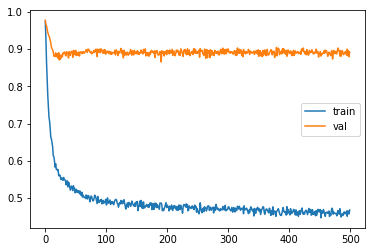

In [25]:
plt.figure()

xs = range(len(history.history["loss"]))
plt.plot(xs, history.history["cpcLoss"], label="train")
plt.plot(xs, history.history["val_cpcLoss"], label="val")
plt.legend(loc="best")
plt.show()
plt.close()

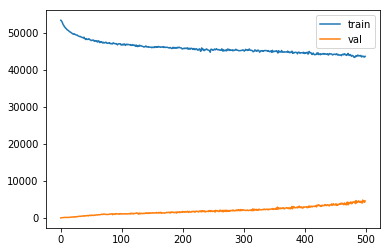

In [26]:
plt.figure()

xs = range(len(history.history["loss"]))
plt.plot(xs, history.history["mean_squared_error"], label="train")
plt.plot(xs, history.history["val_mean_squared_error"], label="val")
plt.legend(loc="best")
plt.show()
plt.close()

### Testing

In [30]:
print("Training results")
Y_pred = model.predict(X_train).reshape(n,m)
print(evaluateAll(Y_train.reshape(n,m), Y_pred, D))

P = MigrationModels.row_normalize(Y_pred)
origin_pop = populationVectors[1][floodedCounties,:].astype(float)
Y_pred  = MigrationModels.productionFunction(origin_pop, P, beta=dbeta)
print(evaluateAll(Y_train.reshape(n,m), Y_pred, D))

print("Testing results")
Y_pred = model.predict(X_test).reshape(n,m)
print(evaluateAll(Y_test.reshape(n,m), Y_pred.reshape(n,m), D))

P = MigrationModels.row_normalize(Y_pred)
origin_pop = populationVectors[2][floodedCounties,:].astype(float)
Y_pred  = MigrationModels.productionFunction(origin_pop, P, beta=dbeta)
print(evaluateAll(Y_test.reshape(n,m), Y_pred, D))

Training results
21693/21693 [==============================] - 0s 3us/step
(0.509479284839432, 0.5001080095763983, 208.54302065885426, 0.18406944794719504, 46.65755064197416, 0.34346096214206234)
(0.4874112203636793, 0.5828805607366423, 206.52007288041796, 0.19982235338804932, 52.69826614011701, 0.46652349574243157)
Testing results
21693/21693 [==============================] - 0s 2us/step
(0.4267332359133378, 0.6917212819849123, 30.704699642191997, 0.1624679187680128, 15.864200896223771, 0.4064591033480086)
(0.30683124043191257, 0.829962555396889, 57.610292179458106, -1.948437324183828, 39.77516357075371, -3.1821080581387884)


Training results

(0.20268315779415233, 0.25978067372470154, 183.41996574423828, 0.3688172929572968, 68.9841328941264, 0.41480945010006)
(0.40437892260323727, 0.5503302637805827, 106.34365096329847, 0.7878294958488541, 71.55839796808867, 0.8401143013717229)

Testing results

(0.24141244256350317, 0.6607402631218423, 23.464095357983346, 0.5108980722781443, 25.468260680448243, 0.7978432956521541)
(0.2673596849306745, 0.8559577137374054, 65.77814601958072, -2.8437488376327114, 43.43043927508875, -1.5520418308398072)

## Unflooded to Unflooded

In [32]:
X_train, Y_train = loadAllPairs(2005, origin_list=unfloodedCounties, destination_list=unfloodedCounties)
X_test, Y_test = loadAllPairs(2006, origin_list=unfloodedCounties, destination_list=unfloodedCounties)

D = distanceMatrix[unfloodedCounties,:][:,unfloodedCounties].astype(float)
n,m = len(unfloodedCounties), len(unfloodedCounties)

dbeta = 0.03570273246681331

In [33]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
joblib.dump(scaler, "output/scaler_unflooded.p")

['output/scaler_unflooded.p']

In [35]:
Y_train_binary = Y_train.copy().astype(int)
Y_train_binary[Y_train>0] = 1

class_counts = dict(collections.Counter(Y_train_binary))
print class_counts
sampleMultiple = 80
print "Keeping %0.4f percent of the majority class" % (float(class_counts[1] * sampleMultiple)/float(class_counts[0]))
class_counts[0] = class_counts[1] * sampleMultiple
print class_counts

X_res, Y_res_binary, res_indices = RandomUnderSampler(ratio=class_counts, return_indices=True, random_state=0).fit_sample(X_train, Y_train_binary)
Y_res = Y_train[res_indices]

print collections.Counter(Y_res_binary)

print(X_res.shape)

{0: 9521723, 1: 82078}
Keeping 0.6896 percent of the majority class
{0: 6566240, 1: 82078}
Counter({0: 6566240, 1: 82078})
(6648318, 4)


### XGBoost

In [ ]:
%%time

model = xgb.XGBRegressor(
    max_depth=6,
    learning_rate=0.35,
    n_estimators=275,
    n_jobs=16
)
model.fit(X_res, Y_res)

print(model.score(X_train, Y_train))
print(model.score(X_test, Y_test))

[20:12:08] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'


In [ ]:
model.save_model("output/xgboost_unflooded.p")

### DL

In [109]:
def baseline_model():
    inputs = Input(shape=(4,))
    x = inputs
    
    x = Dense(128, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    
    outputs = Dense(1, activation="relu")(x)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    optimizer = Adam(lr=0.001)
    #optimizer = SGD(lr=0.001, momentum=0.5, nesterov=True)
    model.compile(loss=cpcLoss, metrics=["mse", cpcLoss], optimizer=optimizer)
    return model

K.clear_session()

#model = baseline_model(X_train.shape[1])
model = keras.wrappers.scikit_learn.KerasRegressor(
    build_fn=baseline_model,
    epochs=200,
    batch_size=2**14,
    #validation_data=(X_val, Y_val),
    verbose=1
)
history = model.fit(X_res, Y_res)

Epoch 1/200
6648318/6648318 [==============================] - 13s 2us/step - loss: 0.6917 - mean_squared_error: 4592.5953 - cpcLoss: 0.6917
Epoch 2/200
6648318/6648318 [==============================] - 13s 2us/step - loss: 0.5874 - mean_squared_error: 4298.1416 - cpcLoss: 0.5874
Epoch 3/200
6648318/6648318 [==============================] - 13s 2us/step - loss: 0.5401 - mean_squared_error: 4119.0193 - cpcLoss: 0.5401
Epoch 4/200
6648318/6648318 [==============================] - 13s 2us/step - loss: 0.5098 - mean_squared_error: 3886.5870 - cpcLoss: 0.5098
Epoch 5/200
6648318/6648318 [==============================] - 13s 2us/step - loss: 0.4922 - mean_squared_error: 3720.6774 - cpcLoss: 0.4922
Epoch 6/200
6648318/6648318 [==============================] - 13s 2us/step - loss: 0.4808 - mean_squared_error: 3562.6620 - cpcLoss: 0.4809
Epoch 7/200
6648318/6648318 [==============================] - 13s 2us/step - loss: 0.4718 - mean_squared_error: 3479.4834 - cpcLoss: 0.4718
Epoch 8/200
6

6648318/6648318 [==============================] - 13s 2us/step - loss: 0.3602 - mean_squared_error: 1838.5243 - cpcLoss: 0.3602
Epoch 116/200
6648318/6648318 [==============================] - 13s 2us/step - loss: 0.3601 - mean_squared_error: 1877.9046 - cpcLoss: 0.3601
Epoch 117/200
6648318/6648318 [==============================] - 13s 2us/step - loss: 0.3566 - mean_squared_error: 1790.5978 - cpcLoss: 0.3566
Epoch 118/200
6648318/6648318 [==============================] - 13s 2us/step - loss: 0.3597 - mean_squared_error: 1845.2121 - cpcLoss: 0.3597
Epoch 119/200
6648318/6648318 [==============================] - 13s 2us/step - loss: 0.3587 - mean_squared_error: 1854.5264 - cpcLoss: 0.3587
Epoch 120/200
6648318/6648318 [==============================] - 13s 2us/step - loss: 0.3610 - mean_squared_error: 1877.7354 - cpcLoss: 0.3610
Epoch 121/200
6648318/6648318 [==============================] - 13s 2us/step - loss: 0.3625 - mean_squared_error: 1942.5554 - cpcLoss: 0.3625
Epoch 122/200

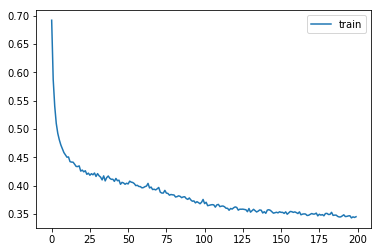

In [110]:
plt.figure()

xs = range(len(history.history["loss"]))
plt.plot(xs, history.history["cpcLoss"], label="train")
plt.legend(loc="best")
plt.show()
plt.close()

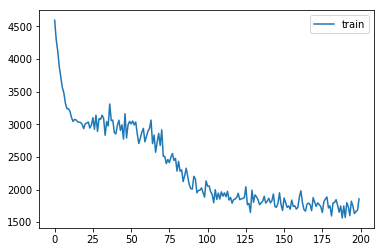

In [111]:
plt.figure()

xs = range(len(history.history["loss"]))
plt.plot(xs, history.history["mean_squared_error"], label="train")
plt.legend(loc="best")
plt.show()
plt.close()

### Testing

In [112]:
print("Training results")
Y_pred = model.predict(X_train).reshape(n,m)
Y_pred[Y_pred<0] = 0
print(evaluateAll(Y_train.reshape(n,m), Y_pred, D))

P = MigrationModels.row_normalize(Y_pred)
P[np.isnan(P) | np.isinf(P)] = 0
origin_pop = populationVectors[1][unfloodedCounties,:].astype(float)
Y_pred  = MigrationModels.productionFunction(origin_pop, P, beta=dbeta)
print(evaluateAll(Y_train.reshape(n,m), Y_pred, D))

print("Testing results")
Y_pred = model.predict(X_test).reshape(n,m)
Y_pred[Y_pred<0] = 0
print(evaluateAll(Y_test.reshape(n,m), Y_pred.reshape(n,m), D))

P = MigrationModels.row_normalize(Y_pred)
P[np.isnan(P) | np.isinf(P)] = 0
origin_pop = populationVectors[2][unfloodedCounties,:].astype(float)
Y_pred  = MigrationModels.productionFunction(origin_pop, P, beta=dbeta)
print(evaluateAll(Y_test.reshape(n,m), Y_pred, D))

Training results
9603801/9603801 [==============================] - 7s 1us/step
(0.6496190604770552, 0.9414913455932127, 33.38011566867385, 0.6733508761266181, 1328.3656774315143, 0.8772515459975879)
(0.6504803207207555, 0.9140285324982789, 33.011530448926905, 0.6805248068069194, 1009.6971372897809, 0.9180699186945335)
Testing results
9603801/9603801 [==============================] - 7s 1us/step
(0.650745108723006, 0.9511189609978187, 31.501790275462803, 0.6719942602667357, 1328.8235778608853, 0.8765610274515744)
(0.6540307154109998, 0.9297472104231046, 30.71544159301535, 0.6881652581417392, 986.4269717760178, 0.9227899400395037)


In [114]:
model.model.save("output/dl_unflooded.p")

Training results

(0.7248605000349113, 0.9939702481150618, 7.309230331534163, 0.9843379315137907, 527.9806552237562, 0.9867623138514617)
(0.6465120095835234, 0.9528470056594501, 17.35217824644925, 0.9117298583320819, 666.5956418817348, 0.9721625763097442)

Testing results

(0.6724460371615912, 0.9913308366790006, 13.378904482472683, 0.9408367424976428, 878.206736565396, 0.9329807295600809)
(0.5988773934511273, 0.9673871182624523, 23.105640739662096, 0.8235397035340455, 897.1545883064925, 0.9285558979392985)